In [1]:
import pandas as pd
import numpy as np
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
#from nltk.book import *

from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

# Read in the data
df = pd.read_csv('feedback_limpio.csv')

df.head()

,Transaction_ID,Clothing_ID,Age,Title,Review_Text,Rating,Recommended_IND,Positive_Feedback_Count,Division_Name,Department_Name,Class_Name
0,100001,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Blouses\n
1,100002,1080,34,NaN,Love this dress!its sooo pretty.i happened to ...,5,1,4,General,Dresses,Blouses\n
2,100003,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Blouses\n
3,100004,1049,50,My favorite buy!,"I love, love, love this jumpsuit. its fun, fli...",5,1,0,General Petite,Bottoms,Blouses\n
4,100005,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses\n


In [2]:
df.dtypes

Transaction_ID              int64
Clothing_ID                 int64
Age                         int64
Title                      object
Review_Text                object
Rating                      int64
Recommended_IND             int64
Positive_Feedback_Count     int64
Division_Name              object
Department_Name            object
Class_Name                 object
dtype: object

In [3]:
df['New_Rate'] = 0
df.loc[df["Rating"] == 5, "New_Rate"] = 1
df.loc[df["Rating"] == 4, "New_Rate"] = 1
df.loc[df["Rating"] == 3, "New_Rate"] = 0
df.loc[df["Rating"] == 2, "New_Rate"] = -1
df.loc[df["Rating"] == 1, "New_Rate"] = -1

print("Total ", len(df))
total = df["Rating"].value_counts()
print(total)
print("Positive ", (total[5]+total[4])*100/len(df))
print("Neutral ", (total[3])*100/len(df))
print("Negative ", (total[1]+total[2])*100/len(df))

Total  22639
Rating
5    12609
4     4890
3     2801
2     1524
1      815
Name: count, dtype: int64
Positive  77.29581695304563
Neutral  12.372454613719688
Negative  10.331728433234684


In [4]:
df["New_Rate"].value_counts()


New_Rate
 1    17499
 0     2801
-1     2339
Name: count, dtype: int64

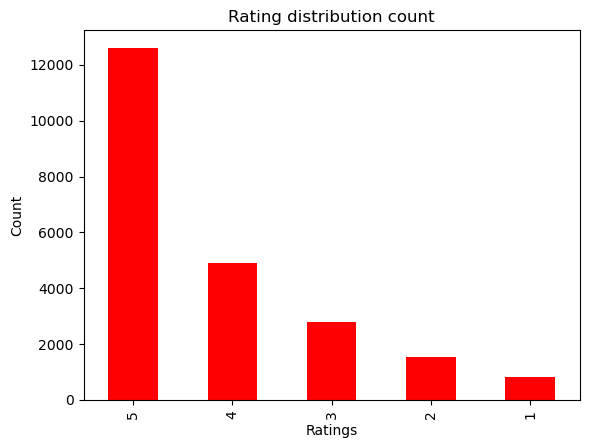

In [5]:
#Bar plot to visualize the total counts of each rating

df['Rating'].value_counts().plot.bar(color = 'red')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

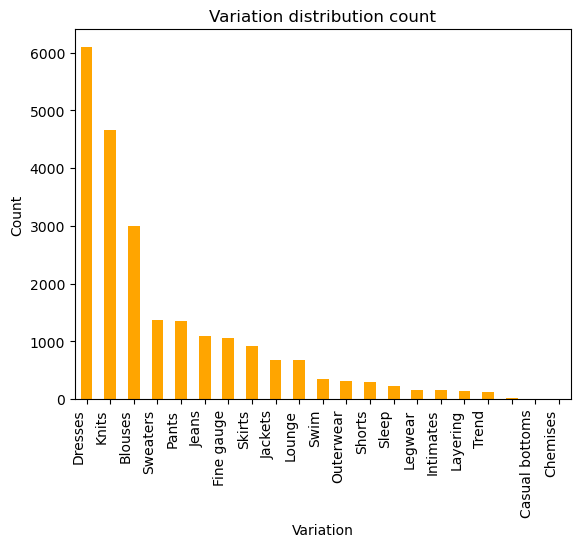

In [6]:
#df["Review_Text"][0]
#print(df['Class_Name'].value_counts())
#Bar graph to visualize the total counts of each variation

df['Class_Name'].value_counts().plot.bar(color = 'orange')
plt.title('Variation distribution count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df['Review_Text'], df['New_Rate'], random_state=0)
X_train.shape

(16979,)

# Pruebas de Vectorizadores

## CountVectorizer plano

In [8]:
vect = CountVectorizer().fit(X_train)

print("Cantidad de propiedades:",  len(vect.get_feature_names_out()))

X_train_vectorized = vect.transform(X_train)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_vectorized, y_train)

predictions = model.predict_proba(vect.transform(X_test))

print('AUC: ', roc_auc_score(y_test, predictions,multi_class='ovr'), "\n")

feature_names = np.array(vect.get_feature_names_out())

sorted_coef_index = model.coef_[0].argsort()

print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))


Cantidad de propiedades: 12816
AUC:  0.6274923567322442 

Smallest Coefs:
['necessary' 'carry' 'layers' 'suited' 'stands' 'rose' 'comparison'
 'grabbed' 'taste' 'understated']

Largest Coefs: 
['surprises' 'budget' 'un' 'billow' 'world' 'trashy' 'nipples' 'stained'
 'sticks' 'baseball']


In [9]:
print(["dress!its"] in feature_names)
print(["?"] in feature_names)

False
False


## Tfidf plano

In [10]:
vect = TfidfVectorizer().fit(X_train)

print("Cantidad de propiedades:",  len(vect.get_feature_names_out()))

X_train_vectorized = vect.transform(X_train)

model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

predictions = model.predict_proba(vect.transform(X_test))

print('AUC: ', roc_auc_score(y_test, predictions,multi_class='ovr'), '\n')

feature_names = np.array(vect.get_feature_names_out())

sorted_tfidf_index = X_train_vectorized.max(0).toarray()[0].argsort()

print('Smallest tfidf:\n{}\n'.format(feature_names[sorted_tfidf_index[:10]]))
print('Largest tfidf: \n{}'.format(feature_names[sorted_tfidf_index[:-11:-1]]))

Cantidad de propiedades: 12816
AUC:  0.6763080670416274 

Smallest tfidf:
['chairs' 'garter' 'pierce' 'toenails' 'spa' 'oohs' 'aaaahs' 'advises'
 'drivers' 'surfaces']

Largest tfidf: 
['birds' 'amp' 'structure' 'lovethis' 'embroidery' 'sweet' 'delicate'
 'loved' 'romantic' 'warn']


## CountVectorizer n-gramas y frecuencia

In [11]:
vect = CountVectorizer(ngram_range=(1,5)).fit(X_train)

print("Cantidad de propiedades:",  len(vect.get_feature_names_out()))

X_train_vectorized = vect.transform(X_train)

model = LogisticRegression(max_iter=500)
model.fit(X_train_vectorized, y_train)

predictions = model.predict_proba(vect.transform(X_test))

print('AUC: ', roc_auc_score(y_test, predictions,multi_class='ovr'), "\n")

feature_names = np.array(vect.get_feature_names_out())

sorted_coef_index = model.coef_[0].argsort()

print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Cantidad de propiedades: 2280213
AUC:  0.6669615446507425 

Smallest Coefs:
['not too' 'amazing' 'tee' 'like it' 'liked' 'the small' 'love this top'
 'perfectly' 'seem' 'pretty']

Largest Coefs: 
['so soft and comfortable' 'cheap' 'so soft and' 'is just' 'disappointed'
 'runs' 'so soft' 'is too' 'looked' 'great color']


## Tfidf n-gramas y frecuencia

In [12]:
vect = TfidfVectorizer(ngram_range=(1,5)).fit(X_train)

print("Cantidad de propiedades:",  len(vect.get_feature_names_out()))

X_train_vectorized = vect.transform(X_train)

model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

predictions = model.predict_proba(vect.transform(X_test))

print('AUC: ', roc_auc_score(y_test, predictions,multi_class='ovr'), '\n')

feature_names = np.array(vect.get_feature_names_out())

sorted_tfidf_index = X_train_vectorized.max(0).toarray()[0].argsort()

print('Smallest tfidf:\n{}\n'.format(feature_names[sorted_tfidf_index[:10]]))
print('Largest tfidf: \n{}'.format(feature_names[sorted_tfidf_index[:-11:-1]]))

Cantidad de propiedades: 2280213
AUC:  0.6938735264571236 

Smallest tfidf:
['amp amp 39 usually' 'big sweater underneath great'
 'big sweater underneath great to' 'when winter hits without big'
 'when winter hits without' 'when winter hits' 'won amp amp amp 39'
 'won amp amp amp' 'won amp amp' 'won amp']

Largest tfidf: 
['love embroidery' 'great fit' 'beautiful colors' 'great style'
 'fits perfect' 'great structure' 'comfy cozy' 'love birds'
 'fits great comfortable' 'beautiful and delicate']


In [13]:
a=model.predict(vect.transform(X_test))
u, c = np.unique(a, return_counts=True)
print(u,c)
print(a)

[-1  0  1] [  11   24 5625]
[1 1 1 ... 1 1 1]


In [14]:
print(["dress!its"] in feature_names)
print(["?"] in feature_names)
print(["?"] in np.array([1,2,"?"]))

False
False
True


## Tfidf analyzer

In [15]:
vect = TfidfVectorizer(min_df=5,ngram_range=(2,5), analyzer="char").fit(X_train)

print("Cantidad de propiedades:",  len(vect.get_feature_names_out()))

X_train_vectorized = vect.transform(X_train)

model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

predictions = model.predict_proba(vect.transform(X_test))

print('AUC: ', roc_auc_score(y_test, predictions,multi_class='ovr'), '\n')

feature_names = np.array(vect.get_feature_names_out())

sorted_tfidf_index = X_train_vectorized.max(0).toarray()[0].argsort()

print('Smallest tfidf:\n{}\n'.format(feature_names[sorted_tfidf_index[:10]]))
print('Largest tfidf: \n{}'.format(feature_names[sorted_tfidf_index[:-11:-1]]))

Cantidad de propiedades: 86974
AUC:  0.6854097446939112 

Smallest tfidf:
['_ con' '___ c' '_ co' '_ c' '__ c' '__ co' 'ns: -' 'os: -' '_ pr'
 '___ p']

Largest tfidf: 
['!!!!!' '!!!!' '__' '..' '----' '-----' '___' '---' '.....' '____']


In [16]:
print(["dress!its"] in feature_names)
print(["!"] in feature_names)
print(["?"] in np.array([1,2,"?"]))

False
False
True


## Prueba texto

In [17]:
# These reviews are now correctly identified
print(model.predict(vect.transform(['not an issue, dress is perfect',
                                    'an issue, dress not perfect'])))

[1 1]


# Prueba de Modelos

In [18]:
vect = TfidfVectorizer(ngram_range=(1,5)).fit(X_train)

print("Cantidad de propiedades:",  len(vect.get_feature_names_out()))

X_train_vectorized = vect.transform(X_train)

Cantidad de propiedades: 2280213


## LogisticRegression

In [19]:
model = LogisticRegression(C=10,class_weight="balanced")
model.fit(X_train_vectorized, y_train)

predictions = model.predict_proba(vect.transform(X_test))

print('AUC: ', roc_auc_score(y_test, predictions, multi_class='ovr'))

AUC:  0.6871645538942128


In [20]:
%%skip
from sklearn.linear_model import LogisticRegressionCV
model = LogisticRegressionCV(random_state=0)
model.fit(X_train_vectorized, y_train)

predictions = model.predict_proba(vect.transform(X_test))

print('AUC: ', roc_auc_score(y_test, predictions, multi_class='ovr'))

## MultinomialNB

In [21]:
model = MultinomialNB()
model.fit(X_train_vectorized, y_train)

predictions = model.predict_proba(vect.transform(X_test))

print('AUC: ', roc_auc_score(y_test, predictions, multi_class='ovr'))

AUC:  0.5633421114580359


In [22]:
model = MultinomialNB(alpha=0.01)
model.fit(X_train_vectorized, y_train)

predictions = model.predict_proba(vect.transform(X_test))

print('AUC: ', roc_auc_score(y_test, predictions, multi_class='ovr'))

AUC:  0.6607219538219489


## SVC

In [23]:
%%skip

model = SVC(kernel="linear", probability=True)
model.fit(X_train_vectorized, y_train)

predictions = model.predict_proba(vect.transform(X_test))
print(predictions)
print('AUC: ', roc_auc_score(y_test, predictions, multi_class='ovr'))

# Agregando features

In [24]:
%%skip
vect = TfidfVectorizer(min_df=5,ngram_range=(2,5), analyzer="char").fit(X_train)

print("Cantidad de propiedades:",  len(vect.get_feature_names_out()))

X_train_vectorized = vect.transform(X_train)

model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

predictions = model.predict_proba(vect.transform(X_test))

print('AUC: ', roc_auc_score(y_test, predictions,multi_class='ovr'), '\n')

feature_names = np.array(vect.get_feature_names_out())

sorted_tfidf_index = X_train_vectorized.max(0).toarray()[0].argsort()

print('Smallest tfidf:\n{}\n'.format(feature_names[sorted_tfidf_index[:10]]))
print('Largest tfidf: \n{}'.format(feature_names[sorted_tfidf_index[:-11:-1]]))

In [25]:
df.head(10)

,Transaction_ID,Clothing_ID,Age,Title,Review_Text,Rating,Recommended_IND,Positive_Feedback_Count,Division_Name,Department_Name,Class_Name,New_Rate
0,100001,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Blouses\n,1
1,100002,1080,34,NaN,Love this dress!its sooo pretty.i happened to ...,5,1,4,General,Dresses,Blouses\n,1
2,100003,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Blouses\n,0
3,100004,1049,50,My favorite buy!,"I love, love, love this jumpsuit. its fun, fli...",5,1,0,General Petite,Bottoms,Blouses\n,1
4,100005,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses\n,1
5,100006,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Blouses\n,-1
6,100007,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Blouses\n,1
7,100008,858,39,"Shimmer, surprisingly goes with lots","I ordered this in carbon for store pick up, an...",4,1,4,General Petite,Tops,Blouses\n,1
8,100009,1077,24,Flattering,I love this dress. i usually get an xs but it ...,5,1,0,General,Dresses,Blouses\n,1
9,100010,1077,34,Such a fun dress!,Im 55 and 125 lbs. i ordered the s petite to m...,5,1,0,General,Dresses,Blouses\n,1


In [26]:
import statistics

pos = df[df["New_Rate"]==1]
neu = df[df["New_Rate"]==0]
neg = df[df["New_Rate"]==-1]
posl = []
neul = []
negl = []

for i in pos.index:
    posl.append(len(pos["Review_Text"][i]))
for i in neu.index:
    neul.append(len(neu["Review_Text"][i]))
for i in neg.index:
    negl.append(len(neg["Review_Text"][i]))
print((statistics.fmean(posl), statistics.fmean(neul), statistics.fmean(negl)))

num_pos = statistics.fmean(pos["Review_Text"].str.count(r'\d'))
num_neu = statistics.fmean(neu["Review_Text"].str.count(r'\d'))
num_neg = statistics.fmean(neg["Review_Text"].str.count(r'\d'))
print((num_pos, num_neu,num_neg))

num_pos = statistics.fmean(pos["Review_Text"].str.count(r'\W'))
num_neu = statistics.fmean(neu["Review_Text"].str.count(r'\W'))
num_neg = statistics.fmean(neg["Review_Text"].str.count(r'\W'))
print((num_pos, num_neu,num_neg))

(304.4140808046174, 314.6536951088897, 312.7682770414707)
(1.7324418538202182, 1.7329525169582292, 1.5545104745617786)
(67.0382307560432, 69.35344519814352, 68.69003847798204)
